In [1]:
import jax
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from typing import Sequence
from functools import partial
from tqdm import tqdm
import optax
import lib

In [8]:
a = jnp.arange(100)
b = jnp.arange(100)*(-1)
print(a)
n_pred_steps = 5
delay_dim = 3
delay = 10
jnp.array([])

def get_one_batch(idx):
    tmp_v = a[idx-(delay_dim-1)*delay:idx+1]
    tmp_i = b[idx: idx+n_pred_steps]
    tmp_pred_v = a[idx+1: idx+n_pred_steps+1]
    return jnp.concatenate((tmp_v, tmp_i, tmp_pred_v))

get_one_batch(30)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


Array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30, -30, -31, -32, -33, -34,
        31,  32,  33,  34,  35], dtype=int32)

In [4]:
class mlp2(nn.Module):
    network_struct: Sequence[int]

    def setup(self) -> None:
        self.layers = [nn.Dense(i) for i in self.network_struct]

    def __call__(self, x):
        x = jnp.atleast_2d(x)
        # x = jnp.concatenate((x, x**2), axis=-1)
        for i in range(len(self.layers)-1):
            x = self.layers[i](x)
            # x = nn.relu(x)
            x = nn.softplus(x)
        x = self.layers[-1](x)
        return x

class mlp3(nn.Module):

    def setup(self) -> None:
        self.layer1 = nn.Dense(10)
        self.layer2 = nn.Dense(50)
        self.layer3 = nn.Dense(10)
        self.layer4 = nn.Dense(1)

    def __call__(self, x):
        x = jnp.atleast_2d(x)
        # x = jnp.concatenate((x, x**2), axis=-1)
        x = self.layer1(x)
        x = nn.softplus(x)
        x = self.layer2(x)
        x = nn.softmax(x)
        x = self.layer3(x)
        x = nn.softplus(x)
        x = self.layer4(x)
        return x

class train2():
    def __init__(self, 
        stimulus_list: Sequence[float], # 1d array
        voltage_list: Sequence[float], # 1d array
        model: lib.prediction_model,
        time_delay: int,
        time_delay_dim: int,
        time_range: Sequence[int], #(start, end, spacing)
        batch_size: int, 
        n_prediction_steps: int=1):

        self.stimulus_list = stimulus_list
        self.voltage_list = voltage_list
        self.model = model
        self.time_delay, self.time_delay_dim = time_delay, time_delay_dim
        self.time_range = time_range
        self.batch_size = batch_size
        self.n_prediction_steps = n_prediction_steps
        self.n_batches = None
        self.batches = None 
        # the shape of batches is (n_batches, batch_size, time_delay_dim + 2)
        # the last dimension of batches is (V(t), V(t-\tau), V(t-2\tau), V(t-3\tau), ...)
        self.loss_list = None

    def get_batches(self, key):
        t_start, t_end, t_spacing = self.time_range
        first_usable_t_idx = self.time_delay*(self.time_delay_dim-1) # the first point that can be used for training is the time_delay*(time_delay_dim-1)^th point.
        n_points = int((t_end-t_start)/t_spacing) - first_usable_t_idx - self.n_prediction_steps # -n_prediction_steps because the prediction always needs the data at the next time step
        tmp_v = jnp.array([jnp.roll(self.voltage_list, i*self.time_delay) for i in range(self.time_delay_dim)]).T
        tmp_v = tmp_v[first_usable_t_idx:-self.n_prediction_steps, :]

        tmp_pred_v = jnp.array([jnp.roll(self.voltage_list[first_usable_t_idx+1:], -i) for i in range(self.n_prediction_steps)]).T
        tmp_pred_v = tmp_pred_v[:len(tmp_pred_v)+1-self.n_prediction_steps]
        tmp_pred_v = tmp_pred_v.reshape((-1, self.n_prediction_steps))

        tmp_i = (self.stimulus_list + jnp.roll(self.stimulus_list, -1))/2
        tmp_i = tmp_i[first_usable_t_idx:-1]
        tmp_i = jnp.array([jnp.roll(tmp_i, -i) for i in range(self.n_prediction_steps)]).T
        tmp_i = tmp_i[:len(tmp_i)+1-self.n_prediction_steps]
        tmp_i = tmp_i.reshape((-1, self.n_prediction_steps))

        tmp = jnp.concatenate((tmp_v, tmp_i, tmp_pred_v), axis=-1) # dim of tmp is (n_points, time_delay_dim+2)
        tmp = jax.random.permutation(key, tmp, axis=0, independent=False)
        self.n_batches = int(n_points/self.batch_size)
        self.batches = tmp[:self.n_batches*self.batch_size, :].reshape((self.n_batches, self.batch_size, -1))
        
    @partial(jax.jit, static_argnums=(0, ))
    def loss(self, params, batch):
        xs = batch[:, :-2*self.n_prediction_steps]
        avg_Is = batch[:, -2*self.n_prediction_steps:-self.n_prediction_steps]
        preds_true = batch[:, -self.n_prediction_steps:]
        for i in range(self.n_prediction_steps):
            preds_tmp = self.model.apply(params, xs[:, i:self.time_delay_dim+i], avg_Is[:, i])
            xs = jnp.concatenate((xs, preds_tmp.reshape((-1, 1))), axis=-1)
        preds = xs[:, -self.n_prediction_steps:]
        return jnp.sum((preds - preds_true)**2)/self.batch_size

    @partial(jax.jit, static_argnums=(0, ))
    def loss_and_grad(self, params, batch):
        return jax.value_and_grad(self.loss, argnums=0)(params, batch)

    def run(self, params, n_epochs, optimizer):
        pbar = tqdm(range(n_epochs))
        tx = optimizer
        # tx = optax.sgd(learning_rate=lr, momentum=0.9)
        opt_state = tx.init(params)
        self.loss_list = np.zeros(n_epochs)
        for i in pbar:
            batch_idx = i%self.n_batches
            # print(batch_idx)
            loss_val, grads = self.loss_and_grad(params, self.batches[batch_idx])
            updates, opt_state = tx.update(grads, opt_state)
            params = optax.apply_updates(params, updates)
            self.loss_list[i] = loss_val
            pbar.set_postfix({"loss": loss_val})
        return params

In [16]:
time_delay_dim = 5
time_delay = 10
time_range = (0, 2000, 0.02)
n_points = len(np.arange(*time_range))
constant_current_duration = 500
n_current_plateaus = n_points//constant_current_duration
np.random.seed(42)
random_i = np.random.uniform(-15, 60, size=(n_current_plateaus, 1))
stimulus_list = (np.ones((n_current_plateaus, constant_current_duration))*random_i).reshape((-1, ))
stimulus = lib.custom_stimulus(stimulus_list=stimulus_list, time_range=time_range, time_constant=10)
training_neuron = lib.single_neuron_odeint(stimulus, [0, 0, 0, 0])
training_neuron.generate_sol()

In [17]:
ann = mlp2((50, 50, 50, 1))
# ann = mlp3()
pred_model = lib.prediction_model(ann, time_spacing=time_range[-1])
params = pred_model.init(jax.random.PRNGKey(0), jnp.zeros((time_delay_dim)), jnp.array([0.]))
train_test = lib.train(stimulus_list=stimulus.stimulus_list, voltage_list=training_neuron.sol[:, 0], model=pred_model, time_delay=time_delay, time_delay_dim=time_delay_dim, time_range=time_range, batch_size=5000)
train_test.get_batches(jax.random.PRNGKey(0))
# optimizer = optax.adam(learning_rate=0.01, b1=0.9, b2=0.9)
# params = train_test.run(params, 1000, optimizer)
optimizer = optax.adam(learning_rate=0.1, b1=0.9, b2=0.9)
params = train_test.run(params, 1000, optimizer)

train_test = lib.train(stimulus_list=stimulus.stimulus_list, voltage_list=training_neuron.sol[:, 0], model=pred_model, time_delay=time_delay, time_delay_dim=time_delay_dim, time_range=time_range, batch_size=99000)
train_test.get_batches(jax.random.PRNGKey(0))
optimizer = optax.adam(learning_rate=0.01, b1=0.9, b2=0.9)
params = train_test.run(params, 1000, optimizer)

100%|██████████| 1000/1000 [01:46<00:00,  9.40it/s, loss=0.34783566]


In [18]:
optimizer = optax.adam(learning_rate=0.002, b1=0.9, b2=0.9)
params = train_test.run(params, 1000, optimizer)

100%|██████████| 1000/1000 [01:48<00:00,  9.23it/s, loss=0.29598862]


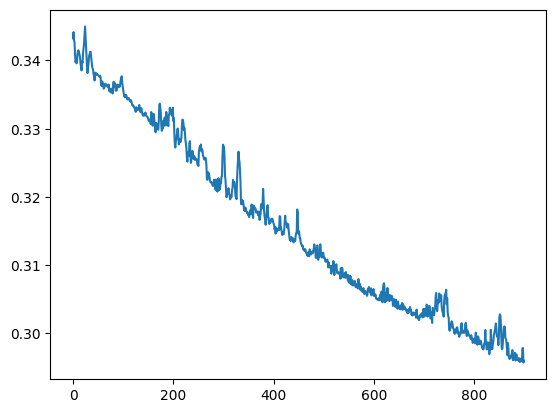

In [21]:
plt.plot(train_test.loss_list[100:])

In [20]:
"""prediction"""
time_range = (0, 1000, 0.02)
stimulus_test = lib.constant_stimulus(dc_stimulus=30, time_range=time_range, time_constant=10)
test_neuron = lib.single_neuron_odeint(stimulus_test, [0, 0., 0., 0])
test_neuron.generate_sol()
initial_piece_len = time_delay*(time_delay_dim-1) + 1
initial_piece = test_neuron.sol[:initial_piece_len, 0]
stimulus_list = stimulus_test.stimulus_list[initial_piece_len:]
pred_run = lib.generate_prediction(pred_model, time_delay, time_delay_dim, stimulus_list, initial_piece)
pred_run.run(params, n_steps=1500)

100%|██████████| 1500/1500 [01:44<00:00, 14.39it/s]


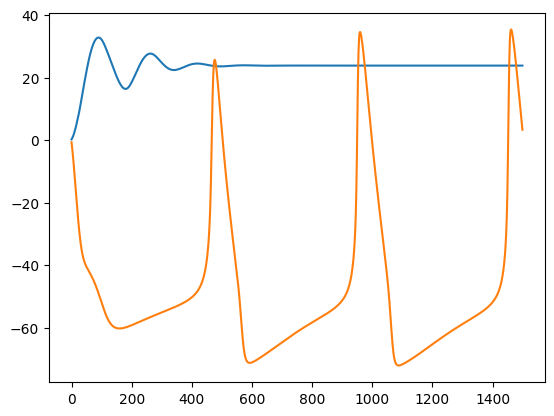

In [25]:
start = initial_piece_len + 0
end = initial_piece_len + 1500
plt.plot(pred_run.prediction_list[start:end])
plt.plot(test_neuron.sol[start:end, 0])

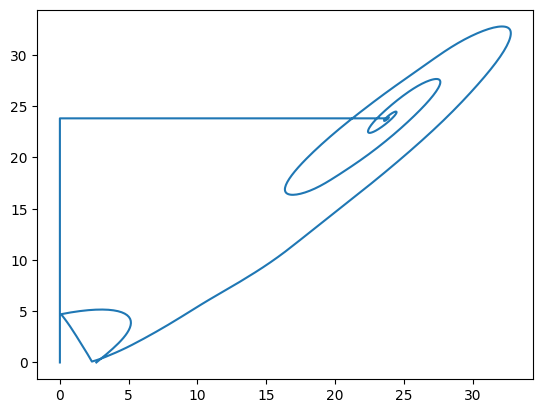

In [24]:
pred_x = pred_run.prediction_list[time_delay:]
pred_y = pred_run.prediction_list[:-time_delay]
plt.plot(pred_x, pred_y)
# plt.plot(np.arange(-80, 40, 1), np.arange(-80, 40, 1))
# plt.xlim(-60, -50)
# plt.ylim(-60, -50)

In [67]:
v_low, v_high, v_spacing = (-80, 40, 1)
vxy_list = jnp.array([[i, j] for i in np.arange(v_low, v_high, v_spacing) for j in np.arange(v_low, v_high, v_spacing)])
vxy_list = vxy_list.reshape((-1, int(round((v_high-v_low)/v_spacing)), 2))
vdx = np.zeros(vxy_list.shape[:-1])

In [ ]:
for i in range(len(vdx)):
    vdx[i] = ann.apply({"params": params["params"]["ann"]}, vxy_list[i])[:, 0]

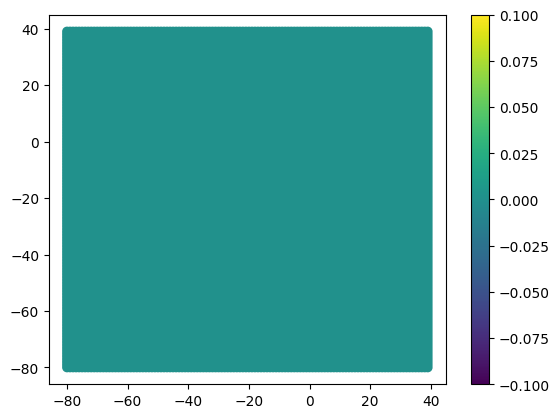

In [69]:
vxy_list = vxy_list.reshape((-1, 2))
vdx = vdx.reshape((-1, ))
plt.scatter(vxy_list[:, 0], vxy_list[:, 1], c=np.clip(vdx, a_min=-1000, a_max=1000))
plt.colorbar()

In [48]:
ann.apply({"params": params["params"]["ann"]}, jnp.array([-67.5, -70]))

Array([[139.18042]], dtype=float32)